In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Bacteria/repo


/content/drive/MyDrive/Bacteria/repo


In [ ]:
!python3 utils.py install

In [ ]:
from utils import *

In [ ]:
#display_image('/content/drive/MyDrive/Bacteria/Output/TRAIN_IMAGES.json','/content/drive/MyDrive/Bacteria/Output/TRAIN_BBOXES.json',1)

In [ ]:
#create_images_and_bbox_list('/content/drive/MyDrive/Bacteria/Orginal_images', '/content/drive/MyDrive/Bacteria/Orginal_measure','/content/drive/MyDrive/Bacteria/Output')



Cropped original images and created 1752 train and 195 test images. Images has been saved to /content/drive/MyDrive/Bacteria/Output .

Found 99053 bounding boxes as train and test. Image path and bbox locations has ben saved to /content/drive/MyDrive/Bacteria/Output. 


In [ ]:
!python3 train.py install


Loaded base model.

Epoch: [0][0/55]	Batch Time 8.240 (8.240)	Data Time 2.524 (2.524)	Loss 7.1762 (7.1762)	
Epoch: [1][0/55]	Batch Time 3.299 (3.299)	Data Time 2.717 (2.717)	Loss 25961887744.0000 (25961887744.0000)	
Epoch: [2][0/55]	Batch Time 2.799 (2.799)	Data Time 2.132 (2.132)	Loss 331477440.0000 (331477440.0000)	
Epoch: [3][0/55]	Batch Time 3.160 (3.160)	Data Time 2.480 (2.480)	Loss 145.0952 (145.0952)	
Epoch: [4][0/55]	Batch Time 3.010 (3.010)	Data Time 2.316 (2.316)	Loss 341349.0938 (341349.0938)	
Epoch: [5][0/55]	Batch Time 3.066 (3.066)	Data Time 2.429 (2.429)	Loss 49.0872 (49.0872)	
Epoch: [6][0/55]	Batch Time 2.741 (2.741)	Data Time 2.155 (2.155)	Loss 29.3688 (29.3688)	
Epoch: [7][0/55]	Batch Time 3.231 (3.231)	Data Time 2.530 (2.530)	Loss 322.2560 (322.2560)	
Epoch: [8][0/55]	Batch Time 2.776 (2.776)	Data Time 2.087 (2.087)	Loss 106.1511 (106.1511)	
Epoch: [9][0/55]	Batch Time 2.507 (2.507)	Data Time 1.927 (1.927)	Loss 1123.0802 (1123.0802)	
Epoch: [10][0/55]	Batch Time 2.

In [ ]:
!python3 eval.py install

Evaluating:   0% 0/7 [00:00<?, ?it/s]/content/drive/MyDrive/Bacteria/repo/model.py:504: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/drive/MyDrive/Bacteria/repo/model.py:506: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])
Evaluating: 100% 7/7 [00:09<00:00,  1.34s/it]
{'bacteria': 1, 'background': 0}
{1: 'bacteria', 0: 'background'}

{'bacteria': 0.8071391582489014}

Mean Average Precision (mAP): 0.807



Loaded checkpoint from epoch 2222.

--- 0.04920673370361328 seconds ---


/content/drive/MyDrive/Bacteria/repo/model.py:504: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/drive/MyDrive/Bacteria/repo/model.py:506: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


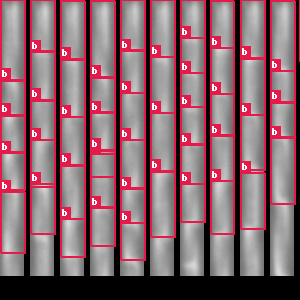

In [ ]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display 
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = '/content/drive/MyDrive/Bacteria/CheckPoints/checkpoint_predefined_8_2lr03_32.pth'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])





def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    
    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
   
   
    # Detect objects in SSD output
    start_time = time.time()
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    print("--- %s seconds ---" % (time.time() - start_time))

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = font = ImageFont.load_default()

    # Suppress specific classes, if needed
    
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
    
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize('b')
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text='b', fill='white',
                  font=font)
    del draw
    
    return annotated_image



img_path ="/content/drive/MyDrive/Bacteria/Output/Original-s17-ss-380-roi-24_1150.jpg"
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
im = detect(original_image, min_score=0.2, max_overlap=0.45, top_k=200)
im


In [ ]:
original_image.show()